# Concolutional Neural Network

## Importation librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv1D, Activation, MaxPooling1D, Flatten, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import time

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

import random

2024-05-15 15:38:36.621752: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 15:38:36.623715: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 15:38:36.649493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 15:38:36.649519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 15:38:36.650205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Importation et affichage données

health: -1.0
[ 0.50205548  0.54216265  0.72238348  1.4288852   2.1365158   2.281149
  1.9362737   1.46889     1.0088451   0.38028224 -0.29677967 -0.51392868
 -0.25564469 -0.10720254 -0.28782655 -0.41800901 -0.31916313 -0.2603787
 -0.35035721 -0.50548599 -0.71088709 -0.82391982 -0.89970154 -1.1539497
 -1.2298306  -1.044091   -1.2020312  -1.3921949  -1.1301083  -1.1798666
 -1.6492718  -1.7265754  -1.6083704  -1.6628022  -1.6506724  -1.6973094
 -1.8386968  -1.8025962  -1.7805361  -1.8251665  -1.6447633  -1.4238097
 -1.3921949  -1.3604156  -1.2001781  -0.91863234 -0.68591581 -0.66794346
 -0.51272154 -0.10169069  0.06395426  0.08261431  0.23760718  0.17479318
  0.12320539  0.5033942   0.6838702   0.47499476  0.53279711  0.72354995
  0.6644198   0.64793559  0.75705403  0.7320716   0.62021499  0.60629677
  0.67795016  0.68908363  0.59880728  0.54264656  0.58180737  0.63063068
  0.6644198   0.6863178   0.65738251  0.65088944  0.72173837  0.73970645
  0.69148052  0.69522947  0.7501145   0.85384

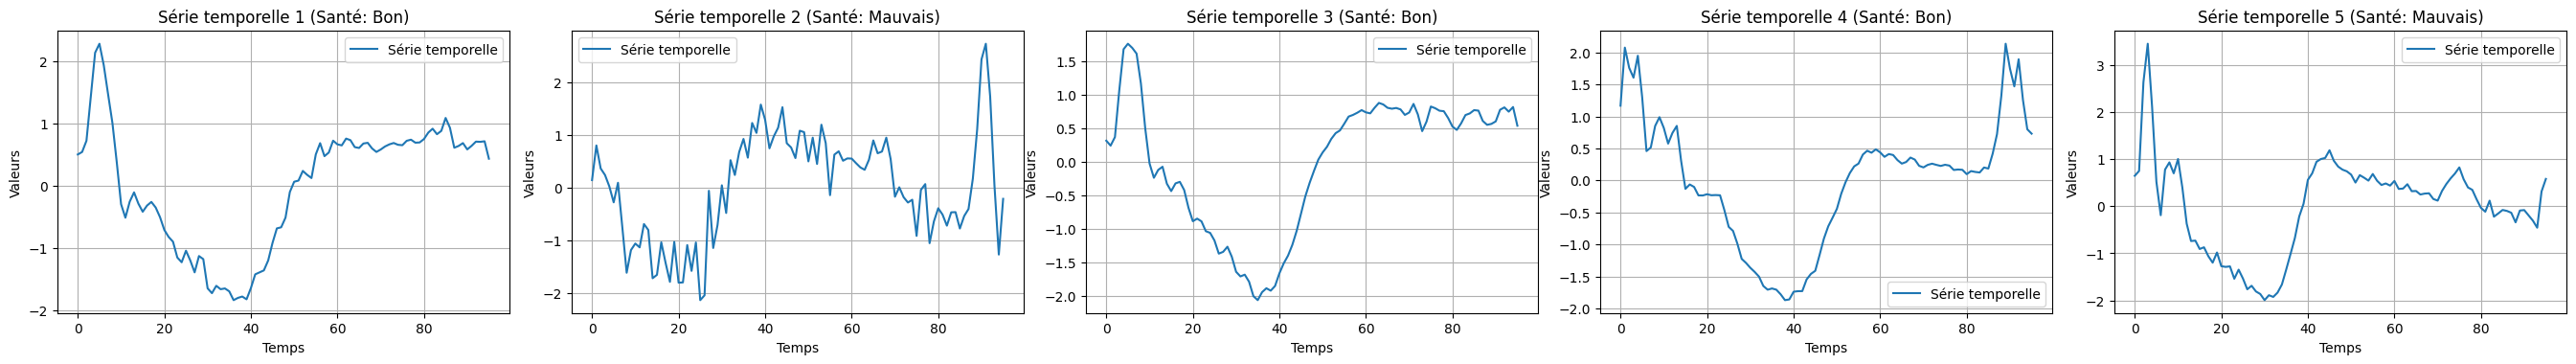

In [2]:
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

# Afficher la première série temporelle
print("health:", train_data[0,0])
print(train_data[0,1:])

# Afficher les dimensions des données
print("Dimensions des données d'entrainnement:", train_data.shape)
print("Dimensions des données de test:", test_data.shape)

# Afficher les 5 premières séries temporelles
nb_series_a_afficher = 5
plt.figure(figsize=(27, 7))
for i in range(nb_series_a_afficher):
    # Extraire la série temporelle et son état de santé correspondant
    serie_temporelle = train_data[i, 1:]
    etat_sante = train_data[i, 0]
    
    # Créer une plage de temps pour l'axe x
    plage_temps = range(len(serie_temporelle))
    
    # Placer la série temporelle dans le sous-graphique correspondant
    plt.subplot(2, nb_series_a_afficher, i+1)
    plt.plot(plage_temps, serie_temporelle, label='Série temporelle')
    plt.xlabel('Temps')
    plt.ylabel('Valeurs')
    plt.title(f'Série temporelle {i+1} (Santé: {"Bon" if etat_sante == -1 else "Mauvais"})')
    plt.legend()
    plt.grid(True)

# Ajuster automatiquement les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()



## Traitement données

In [3]:
# Normaliser les classe
train_data[train_data[:, 0] == -1, 0] = 0
test_data[test_data[:, 0] == -1, 0] = 0

# Séparation des données d'entrainnements et de tests
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# Normaliser les série temporelle entre 0 et 1 dépendament des autres
X_train_normalized = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test_normalized = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

"""# Normaliser les série temporelle entre 0 et 1 indépendament
X_train_normalized = tf.keras.utils.normalize(X_train, axis=1)
X_test_normalized = tf.keras.utils.normalize(X_test, axis=1)"""

# Convertir les étiquettes en encodage one-hot
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

# Afficher la première série temporelle
print("health:", y_train_encoded[0])
print(X_train_normalized[0])
print("Dimensions des données d'entrainnement:", (X_train_normalized.shape, y_train_encoded.shape))


health: [1. 0.]
[0.45761207 0.46349606 0.48993567 0.59358424 0.69739841 0.71861708
 0.66802155 0.59945321 0.53196152 0.43974712 0.34041757 0.30856035
 0.34645235 0.36822981 0.34173105 0.32263241 0.33713377 0.34575784
 0.33255739 0.30979895 0.27966522 0.26308256 0.25196487 0.21466495
 0.20353271 0.23078196 0.20761107 0.17971278 0.21816265 0.21086277
 0.14199786 0.1306569  0.14799837 0.14001286 0.14179239 0.13495042
 0.11420794 0.11950414 0.12274051 0.11619292 0.14265929 0.17507467
 0.17971278 0.18437501 0.20788293 0.24918759 0.28332868 0.28596534
 0.30873744 0.36903844 0.39333967 0.39607722 0.41881572 0.40960049
 0.40203221 0.45780847 0.48428552 0.45364208 0.46212207 0.4901068
 0.48143201 0.47901367 0.49502208 0.49135699 0.47494687 0.47290497
 0.48341701 0.48505036 0.47180621 0.46356706 0.46931221 0.47647492
 0.48143201 0.48464459 0.48039959 0.47944702 0.48984103 0.49247707
 0.485402   0.485952   0.494004   0.50922194 0.51834329 0.50539361
 0.51319193 0.54369595 0.52054742 0.47349203 0.

## Choix des Hyperparamètres

❒ Les hyperparamètres des layers : kernel size, dropout, méthode d’activation des layers cachés, méthode d’activation du layer final, …

❒ Les hyperparamètres de compilation du modèle: optimizer, loss, learning rate …

❒ Les hyperparamètres d’exécution du modèle : batch size, nombre d’epochs, …

In [16]:
# HyperParameter des layers :
# specify filter numbers
filters = 3
# specify filter size
kernel_size = 2
# specify stride size
stride = 1
# 
padding = 'same'
# specify activation
activation = 'relu'
# specify pooling size
pool_size = 1
# taux de déconnexion
dropout_rate = 0.3
# number of classe
nb_classes = 2

# HyperParameter de compilation : 
# choose learning rate
learning_rate = 0.001
# choose the optimization algorithm by specifying the learning rate
optimizer_algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# choose the cost function: categorical cross entropy
cost_function = tf.keras.losses.binary_crossentropy

## HyperParameter d’exécution : 
# choose batch size
mini_batch_size = 16
# choose number of epochs
nb_epochs = 600
# specify the percentage for validation
percentage_of_train_as_validation = 0.2

## Création du modèle

In [17]:
# input
input_shape = (96, 1)
input_layer = Input(input_shape)

# block
conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(input_layer)
relu_layer_1_1 = Activation('relu')(conv_layer_1_1)
conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(relu_layer_1_1)
relu_layer_1_2 = Activation('relu')(conv_layer_1_2)
pooling_layer_1 = MaxPooling1D(pool_size = pool_size, padding='same')(relu_layer_1_2)
dropout_layer_1_1 = Dropout(rate=dropout_rate)(relu_layer_1_1)

# output
flattened_layer = Flatten()(pooling_layer_1)
dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
output_layer = Dense(units=nb_classes, activation='softmax')(dropout_flattened)

model = Model(inputs=input_layer, outputs=output_layer)

## Compilation du modèle

In [18]:
model.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 3)             9         
                                                                 
 activation_4 (Activation)   (None, 96, 3)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 96, 3)             21        
                                                                 
 activation_5 (Activation)   (None, 96, 3)             0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 96, 3)             0         
 g1D)                                                            
                                                           

## Entrainnement du modèle

In [19]:
# specify the model checkpoint (to save the best model for each epoch)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)
#model_checkpoint = model.save('my_model.keras')

# start training
history = model.fit(X_train_normalized, y_train_encoded, 
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])


## Résultats du meilleur modèle

4/4 [==============================] - 0s 2ms/step - loss: 0.4651 - accuracy: 0.8400
Test Loss: 0.4651455581188202
Test Accuracy: 0.8399999737739563


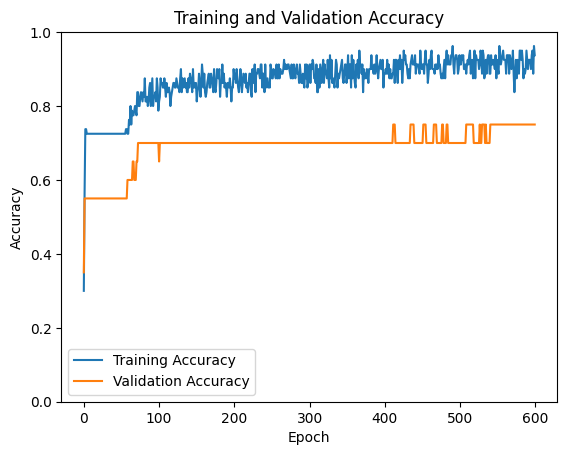

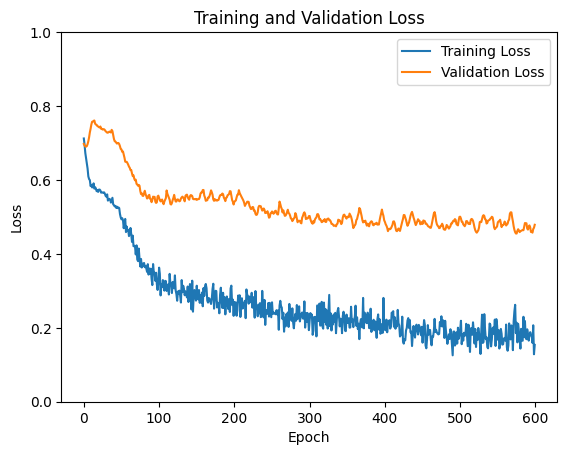

In [20]:

# Charge le meilleur modèle
best_model = tf.keras.models.load_model('best_model_CNN.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_normalized, y_test_encoded)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

## Matrice de confusion

4/4 [==============================] - 0s 1ms/step


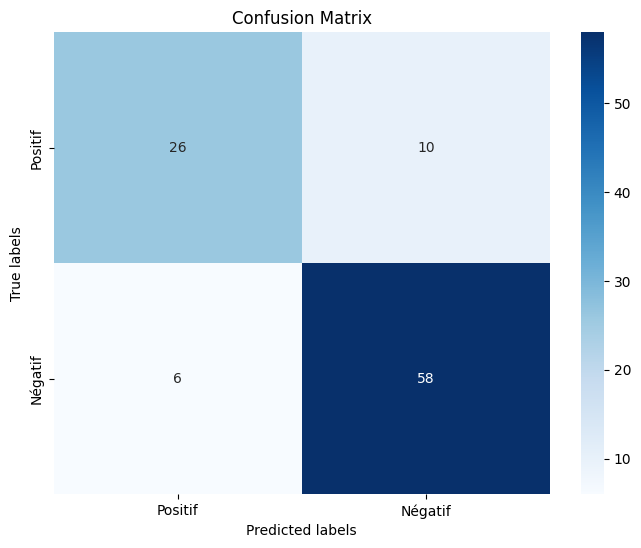

In [21]:
class_names = ['Positif', 'Négatif']

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)    

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Recherche des hyperparamètre
par recherche par grille et recherche aléatoire


## Meilleur modèle


4/4 [==============================] - 0s 1ms/step
Nombre total de paramètres : 482
Temps d'entraînement : 0.0 minutes et 24.301645278930664 secondes.
Test Loss : 0.3823246657848358
Test Accuracy : 0.7900000214576721
AUC-ROC :  0.9071180555555556
Train Loss : 0.24374905228614807
Train Accuracy : 0.8899999856948853


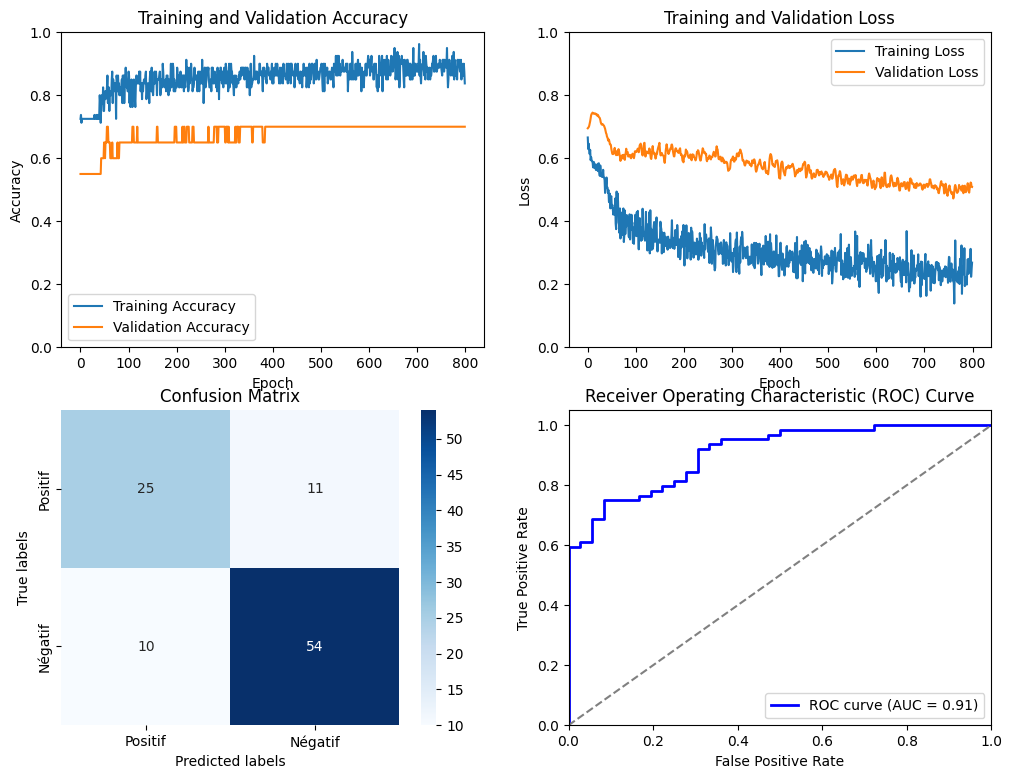

In [25]:
"""
Best hyperparameters:   [(5, 3, 2, 2, 0.2, 16), (5, 3, 1, 1, 0.2, 16), (5, 3, 1, 2, 0.2, 16), 
  (5, 3, 1, 2, 0.2, 16), (5, 3, 1, 2, 0.2, 16), (5, 3, 1, 1, 0.2, 16), (5, 3, 2, 1, 0.2, 16)]
Best hyperparameters 2: [(5, 3, 1, 2, 0.2, 16), (5, 3, 1, 1, 0.2, 16), (5, 3, 2, 1, 0.2, 16), 
  (5, 3, 1, 1, 0.2, 16), (5, 3, 1, 2, 0.2, 16), (5, 3, 1, 2, 0.2, 16)]
Meilleure perte : 0.3860410451889038
Meilleure précision : 0.8700000047683716
Temps d'entraînement des hyperparamètre : 21.0 minutes et 30.839005708694458 secondes.
"""


filters = 5
kernel_size = 3
stride = 1
padding = 'same'
use_bias = False
hidden_activation = 'relu'
final_activation = 'sigmoid' 
pool_size = 2
dropout_rate = 0.2
nb_classes = 2
# learning_rate = 0.006
optimizer_algo = tf.keras.optimizers.Adam()  # (learning_rate=learning_rate)
cost_function = tf.keras.losses.binary_crossentropy
mini_batch_size = 16
nb_epochs = 800
percentage_of_train_as_validation = 0.2

# input
input_shape = (96, 1)
input_layer = Input(input_shape)
conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(input_layer)
relu_layer_1_1 = Activation(hidden_activation)(conv_layer_1_1)
conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_1_1)
relu_layer_1_2 = Activation(hidden_activation)(conv_layer_1_2)
pooling_layer_1 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_1_2)
dropout_layer_1_1 = Dropout(rate=dropout_rate)(pooling_layer_1)
conv_layer_2_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(dropout_layer_1_1)
relu_layer_2_1 = Activation(hidden_activation)(conv_layer_2_1)
conv_layer_2_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_2_1)
relu_layer_2_2 = Activation(hidden_activation)(conv_layer_2_2)
pooling_layer_2 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_2_2)
flattened_layer = Flatten()(pooling_layer_2)
dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
output_layer = Dense(units=nb_classes,activation=final_activation)(dropout_flattened)

# build and compil model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])

# specify the model checkpoint (to save the best model for each epoch)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)

# start training
start_time = time.time()
history = model.fit(X_train_normalized, y_train_encoded, 
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])
end_time = time.time()

# Eveluate best model
best_model = tf.keras.models.load_model('best_model_CNN.keras')
train_loss, train_accuracy = best_model.evaluate(X_train_normalized, y_train_encoded)
test_loss, test_accuracy = best_model.evaluate(X_test_normalized, y_test_encoded)
y_pred = best_model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
fpr, tpr, thresholds = roc_curve(y_test_encoded[:, 1], y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# result
class_names = ['Positif', 'Négatif']
tf.keras.utils.plot_model(best_model, show_shapes=True)
training_time_seconds = end_time - start_time
print(f"Nombre total de paramètres : {best_model.count_params()}")
print(f"Temps d'entraînement : {training_time_seconds // 60} minutes et {training_time_seconds % 60} secondes.")
print(f"Test Loss : {test_loss}")
print(f"Test Accuracy : {test_accuracy}")
print(f"AUC-ROC : ", roc_auc)
print(f"Train Loss : {train_loss}")
print(f"Train Accuracy : {train_accuracy}")

# Plot 
plt.figure(figsize=(12, 9))# mettre plus d'espace
# Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
# Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
# Confusion Matrix
plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
# ROC Curve
plt.subplot(2, 2, 4)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')


In [11]:
# Nombre de test
num_trials = 5

# Liste pour stocker les scores de validation
accuracy_scores = []
loss_scores = []

# Boucle pour obtenir la moyenne
for k in range(num_trials):
    # Mélanger les indices des données
    indices = np.arange(len(X_train_normalized))
    np.random.shuffle(indices)

    # Sélectionner des données mélangées pour l'entraînement
    X_train_shuffled = X_train_normalized[indices]
    y_train_shuffled = y_train_encoded[indices]

    # Entraîner le modèle sur les données d'entraînement
    history = model.fit(X_train_shuffled, y_train_shuffled, 
                        batch_size=mini_batch_size, 
                        epochs=nb_epochs,
                        validation_split=percentage_of_train_as_validation,
                        verbose=False,
                        callbacks=[model_checkpoint])
    
    # Évaluer le modèle sur les données de validation
    train_loss, train_accuracy = model.evaluate(X_train_shuffled, y_train_shuffled)
    val_loss, val_accuracy = model.evaluate(X_test_normalized, y_test_encoded)
    
    accuracy_scores.append(val_accuracy)
    loss_scores.append(val_loss)

# Calculer la moyenne des scores de validation
print(np.mean(accuracy_scores))
print(np.mean(loss_scores))



KeyboardInterrupt: 